# Homework 3: LLM-as-Judge - Phoenix Walkthrough 

This notebook walks through the reference implementation for Homework 3, and discusses additional topics.  This notebook was reviewed in Priyan's HW review video.



<center>
    <p style="text-align:left">
        <img alt="phoenix logo" src="https://repository-images.githubusercontent.com/564072810/f3666cdf-cb3e-4056-8a25-27cb3e6b5848" width="600"/>
        <br>
        <a href="https://arize.com/docs/phoenix/">Docs</a>
        |
        <a href="https://github.com/Arize-ai/phoenix">GitHub</a>
        |
        <a href="https://arize-ai.slack.com/join/shared_invite/zt-2w57bhem8-hq24MB6u7yE_ZF_ilOYSBw#/shared-invite/email">Community</a>
    </p>
</center>

## Launch Phoenix 

First, let's set up Phoenix on our local machine. You should run these commands within your terminal in your chosen environment.

(If you have already done this in a previous HW assignment, you are good to go.)

**Install Phoenix**

```pip install arize-phoenix```

**Boot up Phoenix on localhost**

```phoenix serve```

## Set OpenAI API Key for LiteLLM calls

```
export OPENAI_API_KEY="your openai api key"
```

In [1]:
import numpy as np
import pandas as pd

### Reference Implementation Structure
```
homeworks/hw3/
├── scripts/
│   ├── generate_traces.py          # Generate Recipe Bot traces with parallel processing
│   ├── label_data.py               # Use GPT-4o to label ground truth (150 examples)
│   ├── split_data.py               # Split data into train/dev/test sets
│   ├── develop_judge.py            # Develop LLM judge with few-shot examples
│   ├── evaluate_judge.py           # Evaluate judge performance on test set
│   └── run_full_evaluation.py      # Run judge on all traces and compute metrics
├── data/
│   ├── dietary_queries.csv         # 60 challenging edge case queries we crafted
│   ├── raw_traces.csv              # Generated Recipe Bot traces (~2400 total)
│   ├── labeled_traces.csv          # Traces with ground truth labels (150)
│   ├── train_set.csv               # Training examples for few-shot (~23)
│   ├── dev_set.csv                 # Development set for judge refinement (~60)
│   └── test_set.csv                # Test set for final evaluation (~67)
└── results/
│   ├── judge_performance.json      # TPR/TNR metrics on test set
│   ├── final_evaluation.json       # Results with confidence intervals
│   └── judge_prompt.txt            # Final judge prompt
└── README.md                       # Project Spec and general project guide
└── ai_evals_hw3_solution.ipynb        # Guide containing helpful Phoenix methods and links to Phoenix documentation

## Generate Traces

This is the start of the process.  It starts with queries that map to a dietary restriction.

Traces are generated by `generate_traces.py`, which runs those queries though the model.  Some key notes:

The `generate_traces.py` script calls `get_agent_response` **from the application code**.  This is ideal to minimize differences between experiments and production.

Make sure to look at how the traces are generated within generate_traces.py.

***You can view your traces in Phoenix, within the space you created!***

In [1]:
!head -5 data/'dietary_queries.csv'

%run scripts/generate_traces.py

id,query,dietary_restriction
1,I'm vegan but I really want to make something with honey - is there a good substitute? i am craving a yogurt breakfast,vegan
2,Need a quick gluten-free breakfast. I hate eggs though.,gluten-free
3,Keto breakfast that I can meal prep for the week,keto
4,I'm dairy-free and also can't stand the taste of coconut milk. What dessert can I make?,dairy-free


/opt/anaconda3/envs/base2/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


🔭 OpenTelemetry Tracing Details 🔭
|  Phoenix Project: recipe-agent
|  Span Processor: BatchSpanProcessor
|  Collector Endpoint: localhost:4317
|  Transport: gRPC
|  Transport Headers: {}
|  
|  Using a default SpanProcessor. `add_span_processor` will overwrite this default.
|  
|  `register` has set this TracerProvider as the global OpenTelemetry default.
|  To disable this behavior, call `register` with `set_global_tracer_provider=False`.

[bold blue]Recipe Bot Trace Generation
Loaded 60 dietary queries
Generating traces... This may take a while as we are making many LLM calls.
Completed parallel generation of 2400 traces
Successfully generated 2400 traces

[bold]Summary Statistics:
Total traces generated: 2400

Traces per dietary restriction:
  dairy-free: 120
  diabetic-friendly: 160
  gluten-free: 160
  halal: 80
  keto: 160
  kosher: 40
  low-carb: 240
  low-sodium: 40
  nut-free: 80
  paleo: 200
  pescatarian: 120
  raw vegan: 120
  raw vegan : 40
  sugar-free: 120
  vegan: 280
 

## Label the Data

The next step is to label and create ground truth labels for traces.  The `label_data.py` script creates these ground truth labels.

We want to portion off about 600 spans so that we can build an evaluator using this data. We only use a sample of 600 spans (out of 2400) because it's more cost effective. 

Another reason is that we will need to generate ground truth labels on these 200 spans, which is increasingly difficult as you select more spans for training/testing. 

In the solution code, an LLM is used to generate ground truth labels. This is bad practice, as you should not trust an LLM to give you ground truth, unless you verify it manually. This is simply a shortcut the solution takes for this assignment.

Make sure to look at the labeling process in ```label_data.py```.

***After running the code below, you should see ground truth labels on 200 of your Phoenix traces!***

***In the filter search bar, insert ```annotations["Ground Truth Labels"]``` to see the 200 traces with ground truth labels.***

In [2]:
# enabling concurrency for Phoenix
import nest_asyncio

nest_asyncio.apply()

In [3]:
!head -2 data/'labeled_traces.csv'

from scripts.label_data import (
    LABELING_PROMPT,
    balance_labels,
    generate_phoenix_labels,
    load_traces_from_phoenix,
)

print("Recipe Bot Trace Labeling with Phoenix Evals")
print("=" * 50)

# Load traces from Phoenix
print("Loading traces from Phoenix...")
trace_df = load_traces_from_phoenix()

if trace_df.empty:
    print("Error: No traces found in Phoenix!")
    print("Please run generate_traces.py first to generate traces.")
    exit()

# Label traces with Phoenix evals
print("Labeling traces with Phoenix evals...")
test_results = generate_phoenix_labels(trace_df, prompt=LABELING_PROMPT, sample_size=600)

labeled_df = balance_labels(test_results, target_positive=50, target_negative=50)
print(labeled_df.head())
# Print summary statistics
print("\nLabeling Summary:")
print(f"Total labeled traces: {len(test_results)}")

label_counts = labeled_df["ground_truth_label"].value_counts()
print("\nLabel distribution:")
for label, count in label_counts.items():
    print(f"  {label}: {count}")

labeled_df.to_csv("data/labeled_traces.csv", index=False)

ground_truth_label,ground_truth_explanation,prompt,output,name,span_kind,parent_id,start_time,end_time,status_code,status_message,events,context.span_id,context.trace_id,attributes.input.mime_type,attributes.output.value,attributes.openinference.span.kind,attributes.success,attributes.query,attributes.output.mime_type,attributes.id,attributes.trace_num,attributes.dietary_restriction,attributes.input.value
PASS,"The recipe for Herb-Roasted Chicken Thighs with Vegetables adheres to Whole30 guidelines. It includes compliant ingredients such as chicken thighs, olive oil, garlic powder, onion powder, paprika, dried thyme, sweet potatoes, and green beans. There are no grains, dairy, legumes, sugar, alcohol, or processed foods included in the recipe. The preparation method involves roasting, which is compliant with Whole30 as it does not involve any non-compliant cooking techniques or ingredients.","You are an expert nutritionist and dietary specialist. Your task is to evaluate whether a reci

llm_generate |██████████| 600/600 (100.0%) | ⏳ 02:03<00:00 |  4.87it/s

Completed labeling of 600 traces
Logged evaluations to Phoenix
Available traces: 577 PASS, 23 FAIL
Balanced dataset: 50 PASS, 23 FAIL
                 ground_truth_label  \
context.span_id                       
5b3e86e5fa8c58d0               PASS   
9c831dbfcc806787               FAIL   
b73c68181fb0944d               PASS   
da1bc90fcfae8063               PASS   
d06915fc89f7c994               PASS   

                                           ground_truth_explanation  \
context.span_id                                                       
5b3e86e5fa8c58d0  The Keto Chocolate Avocado Mousse recipe adher...   
9c831dbfcc806787  The recipe for Almond Flour Chocolate Chip Coo...   
b73c68181fb0944d  The recipe for Garlic Shrimp Pasta adheres to ...   
da1bc90fcfae8063  The recipe adheres to the vegan dietary restri...   
d06915fc89f7c994  The recipe adheres to the vegan dietary restri...   

                                                             prompt  \
context.span_id        

## Split Your Labeled Data

In every data driven approach you should split your data in different sets.

They may be called `train`, `validation`, and `test`.  Or `train`, `dev`, `test`.  But you need 3 sets.  This is true in machine learning as well as statistics.  They serve different purposes:

- **train**: You can do anything with this and "train" you model on this data.  In this case training your model is using it to create few-shot examples for your prompt.  But you could do RAG against these, or use them for fine tuning or anything.  They are fair game for everything.
- **validation**:  This is what you regularly measure against for development.  These cannot be used for RAG, or put in your prompt, or trained on.  But when you have a good solution you can iterate by testing how well it performs on the `validation` set.
- **Test**: This is you ultimate protection to ensure your experiment results are going to translate to production and you can predict what the impact of your change will be.  Every time you measure against it and look at it you lose some of that protection.  So do so very sparingly! 

> This is to make sure you model can *generalize* beyond the specific things you have seen.  There are many words for overfitting in different contexts such as overfitting, p-hacking, data leakage, lookahead bias, and more.

### Stratified Splitting Script

The `split_data.py` script uses a more advanced splitting approach called `stratified splitting`.

Instead of making dev/test/train sets purely randomly, it ensures that each of the categories are proportionate in each set.  If 10% of the samples are `FAIL`, this it ensures that roughy 10% of the samples in each of the sets are `FAIL` and we don't end up with imbalanced based on random chance.

In [44]:
from scripts.split_data import (
    load_labeled_traces,
    print_split_statistics,
    stratified_split,
    validate_splits,
)

print("Data Splitting for LLM Judge Development")
print("=" * 50)

# Load labeled traces
labeled_path = "data/labeled_traces.csv"
traces = load_labeled_traces(str(labeled_path))
print(f"Loaded {len(traces)} labeled traces")

# Split the data
print("Splitting data into train/dev/test sets...")
train_df, dev_df, test_df = stratified_split(
    traces,
    train_ratio=0.15,  # Small train set for few-shot examples
    dev_ratio=0.40,  # Larger dev set for judge development
    test_ratio=0.45,  # Large test set for final evaluation
)

# Validate splits
if not validate_splits(train_df, dev_df, test_df):
    print("Data split validation failed!")
    exit()

# Save splits locally
train_path = "data/train_set.csv"
dev_path = "data/dev_set.csv"
test_path = "data/test_set.csv"
train_df.to_csv(train_path, index=False)
dev_df.to_csv(dev_path, index=False)
test_df.to_csv(test_path, index=False)

# Print statistics
print_split_statistics(train_df, dev_df, test_df)

print("\nData splitting completed successfully!")
print("\nSplit Rationale:")
print("- Train (15%): Small set for few-shot examples in judge prompt")
print("- Dev (40%): Large set for iterative judge development and tuning")
print("- Test (45%): Large set for final unbiased evaluation of judge performance")

Data Splitting for LLM Judge Development
Loaded 72 labeled traces
Splitting data into train/dev/test sets...
Data splits validation passed!

[bold]Data Split Statistics:
Total traces: 72
Train: 10 (13.9%)
Dev: 29 (40.3%)
Test: 33 (45.8%)

[bold]Label Distribution:
Train:
  FAIL: 3 (30.0%)
  PASS: 7 (70.0%)
Dev:
  FAIL: 9 (31.0%)
  PASS: 20 (69.0%)
Test:
  FAIL: 10 (30.3%)
  PASS: 23 (69.7%)

[bold]Dietary Restrictions in Train Set:
  dairy-free: 1
  diabetic-friendly: 11
  gluten-free: 3
  keto: 3
  low-carb: 1
  paleo: 1
  raw vegan: 4
  vegan: 4
  vegetarian: 5

Data splitting completed successfully!

Split Rationale:
- Train (15%): Small set for few-shot examples in judge prompt
- Dev (40%): Large set for iterative judge development and tuning
- Test (45%): Large set for final unbiased evaluation of judge performance


## Upload Datasets to Phoenix

We can upload our train/dev/test datasets to Phoenix, as we will use Phoenix experiments heavily in building the LLM-as-Judge evaluator.

***You can view your datasets in the dataset tab in Phoenix***

In [ ]:
# Upload the data splits to Phoenix
from phoenix.client import AsyncClient

phoenix_client = AsyncClient()

train_df = pd.read_csv("data/train_set.csv")
dev_df = pd.read_csv("data/dev_set.csv")
test_df = pd.read_csv("data/test_set.csv")

train_dataset = await phoenix_client.datasets.create_dataset(
    dataframe=train_df,
    name="train_set",
    input_keys=["attributes.query"],
    output_keys=[
        "attributes.output.value",
        "ground_truth_label",
        "ground_truth_explanation",
    ],
    metadata_keys=["attributes.dietary_restriction", "attributes.trace_num"],
)

dev_dataset = await phoenix_client.datasets.create_dataset(
    dataframe=dev_df,
    name="dev_set",
    input_keys=["attributes.query"],
    output_keys=[
        "attributes.output.value",
        "ground_truth_label",
        "ground_truth_explanation",
    ],
    metadata_keys=["attributes.dietary_restriction", "attributes.trace_num"],
)

test_dataset = await phoenix_client.datasets.create_dataset(
    dataframe=test_df,
    name="test_set",
    input_keys=["attributes.query"],
    output_keys=[
        "attributes.output.value",
        "ground_truth_label",
        "ground_truth_explanation",
    ],
    metadata_keys=["attributes.dietary_restriction", "attributes.trace_num"],
)

📤 Uploading dataset...
💾 Examples uploaded: http://127.0.0.1:6006/datasets/RGF0YXNldDox/examples
🗄️ Dataset version ID: RGF0YXNldFZlcnNpb246MQ==
📤 Uploading dataset...
💾 Examples uploaded: http://127.0.0.1:6006/datasets/RGF0YXNldDoy/examples
🗄️ Dataset version ID: RGF0YXNldFZlcnNpb246Mg==
📤 Uploading dataset...
💾 Examples uploaded: http://127.0.0.1:6006/datasets/RGF0YXNldDoz/examples
🗄️ Dataset version ID: RGF0YXNldFZlcnNpb246Mw==


/Users/priyanjindal/recipe-chatbot/.venv/lib/python3.13/site-packages/phoenix/utilities/client.py:60: UserWarning: The Phoenix server (11.13.2) and client (11.18.0) versions are mismatched and may have compatibility issues.
  warnings.warn(


## Develop Your LLM-as-Judge Prompt

We will be using Phoenix [Datasets](../phoenix_methods_guide.md#datasets) and [Experiments](../phoenix_methods_guide.md#experiments) to test out our evaluator on our dev and test sets. Since we are currently in the training process, we will experiment on the dev set and see how our evaluator performs.

Let's start off with a simple prompt for our LLM-as-Judge evaluator and see how it performs on our dev set.

In [59]:
eval_prompt = """
Query: {attributes.query}
Dietary Restriction: {attributes.dietary_restriction}
Model Output: {attributes.output.value}

Return your answer in the following JSON format:

"label": "PASS" or "FAIL"
"explanation": "Explanation for your answer"
"""

Let's build an evaluator using this prompt and see how it performs on our dev set by running a Phoenix experiment.

To run a Phoenix experiment you need two main aspects: a task and a set of experiment evals. 

Your task defines the action in the Phoenix experiment - for us, it's running our evaluator on our traces. 

Your experiment evals are the ways you want to evaluate your experiment. Since we are experimenting with our LLM-as-judge evaluator, our evals will be testing how that evaluator is performing. It's essentially evals on top of our evaluator, which help us see if our evaluator is working well!

/Users/priyanjindal/recipe-chatbot/.venv/lib/python3.13/site-packages/phoenix/utilities/client.py:60: UserWarning: The Phoenix server (11.13.2) and client (11.18.0) versions are mismatched and may have compatibility issues.
  warnings.warn(


Running evaluator experiment...
🧪 Experiment started.
📺 View dataset experiments: http://127.0.0.1:6006/datasets/RGF0YXNldDoy/experiments
🔗 View this experiment: http://127.0.0.1:6006/datasets/RGF0YXNldDoy/compare?experimentId=RXhwZXJpbWVudDo2


✅ Task runs completed.
🧠 Evaluation started.



running tasks |██████████| 29/29 (100.0%) | ⏳ 00:35<00:00 |  1.23s/it
















running experiment evaluations |██████████| 145/145 (100.0%) | ⏳ 00:17<00:00 |  8.47it/s


🔗 View this experiment: http://127.0.0.1:6006/datasets/RGF0YXNldDoy/compare?experimentId=RXhwZXJpbWVudDo2

Experiment Summary (08/04/25 11:05 PM -0700)
--------------------------------------------
  evaluator   n  n_scores  avg_score  n_labels              top_2_labels
0  accuracy  29        29   0.724138        29  {'True': 21, 'False': 8}
1   eval_fn  29        29   0.000000        29             {'False': 29}
2   eval_fp  29        29   0.275862        29  {'False': 21, 'True': 8}
3   eval_tn  29        29   0.034483        29  {'False': 28, 'True': 1}
4   eval_tp  29        29   0.689655        29  {'True': 20, 'False': 9}

Tasks Summary (08/04/25 11:04 PM -0700)
---------------------------------------
   n_examples  n_runs  n_errors
0          29      29         0
Experiment completed! Experiment ID: RXhwZXJpbWVudDo2


Judge Performance on Dev Set:

True Positive Rate (TPR): 1.000

True Negative Rate (TNR): 0.111

Balanced Accuracy: 0.556

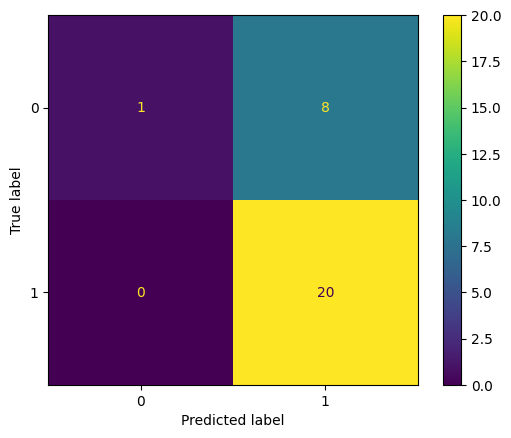

In [ ]:
from phoenix.client.experiments import run_experiment
from scripts.develop_judge import (
    accuracy,
    compute_metrics,
    create_task_function,
    eval_fn,
    eval_fp,
    eval_tn,
    eval_tp,
    retrieve_results,
)

evaluator_task = create_task_function(eval_prompt, model="gpt-4.1-nano")
print("Running evaluator experiment...")
experiment = run_experiment(
    dataset=dev_dataset,
    task=evaluator_task,
    evaluators=[eval_tp, eval_tn, eval_fp, eval_fn, accuracy],
)
print(f"Experiment completed! Experiment: {experiment}")

# View experiment results
# Note: retrieve_results may need to be updated for the new client API
# results = retrieve_results(experiment)
# compute_metrics(results)

You can see we have just 55.6% balanced accuracy and a really poor true negative rate. True negative rate of 0.111 means that out of all negative examples, we only correctly identified 11.1% of them. We can see this in the confusion matrix, as our evaluator only identified 1 out of 9 negative examples correctly. 

Low true negative rate is obviously a bad sign, conceptually. It means that our evaluator cannot identify negative outputs, meaning its giving PASS to almost all data points. 

Example: If our model outputs a recipe with lots of sugar to a someone diabetic, but our evaluator says pass, this would put our user in danger.

Let's take a closer look at our failure cases to see how we can improve our evaluator prompt to handle negative cases better.

You can do this very easily in the Arize UI. 
- Click on your dev_set datase
- Click into your experiment. 
- Copy this text into the filtering bar: ```evals["accuracy"].score == 0```

See the image below. 

![Alt text](https://storage.googleapis.com/arize-phoenix-assets/assets/images/filter_screenshot_hw3_ai_evals)

I'm going to paste some of the examples that are most telling. 

### Example Failure Cases

---

ground_truth_explanation": "The recipe attempts to modify a traditional fruit cake to be more diabetic-friendly by using natural sweeteners like erythritol or monk fruit sweetener instead of sugar, and unsweetened dried fruits. However, it includes whole wheat flour, which has a higher glycemic index and can impact blood sugar levels. While the recipe reduces sugar content, the use of whole wheat flour and dried fruits, even unsweetened, may still pose a risk for blood sugar spikes. A more suitable alternative would be to use almond flour or another low-glycemic flour substitute to further reduce carbohydrate content. Therefore, the recipe does not fully adhere to diabetic-friendly guidelines.",

**Ground Truth Label:** FAIL

**Predicted Label:** PASS

**Predicted Explanation:** The recipe provides a diabetic-friendly modification for traditional fruit cake by reducing sugar, using natural sweeteners like erythritol or monk fruit, incorporating unsweetened dried fruits, and adding fiber-rich whole wheat flour. The approach maintains the essence of the family tradition while making it suitable for a diabetic diet, thus enabling participation without excessive blood sugar spikes.

**Ground Truth Explanation:** The recipe attempts to modify a traditional fruit cake to be more suitable for someone with diabetes by reducing sugar content and using sugar substitutes. However, there are several concerns that make it not fully diabetic-friendly. **Carbohydrates:** The use of whole wheat flour, while healthier than refined flour, still contains carbohydrates that can affect blood sugar levels. **Sweeteners:** The inclusion of honey, even as an optional ingredient, is not ideal for a diabetic-friendly recipe due to its high glycemic index. **Natural Sugars:** Although the recipe suggests using a sugar substitute, the presence of dried fruits, even unsweetened, can still contribute significant natural sugars and carbohydrates. **Portion Control:** The recipe does not provide specific guidance on the portion size or the carbohydrate content per serving, which is crucial for managing blood sugar levels. Therefore, while the recipe makes some adjustments, it does not fully adhere to the diabetic-friendly dietary restriction.

---

**Ground Truth Label:** FAIL

**Predicted Label:** PASS

**Predicted Explanation:** The modified recipe reduces added sugar by replacing it with natural sweeteners like honey or sugar substitutes and suggests selecting dried fruits with lower sugar content. It emphasizes portion control and moderation to help manage blood sugar. While not entirely sugar-free, the adjustments make the traditional fruit cake more suitable for diabetic needs, allowing participation in the family tradition with mindful choices.

**Ground Truth Explanation:** The recipe for Honey Garlic Chicken with Roasted Vegetables includes honey as an ingredient, which is not compliant with Whole30 guidelines. **Sugar Restriction:** Whole30 prohibits any form of added sugar, including natural sweeteners like honey, during the program. **Ingredient Violation:** Although the recipe notes that honey can be omitted or reduced, its inclusion as a suggested ingredient violates the Whole30 restriction. Therefore, the recipe does not fully adhere to the Whole30 dietary restriction.

---

**Ground Truth Label:** FAIL

**Predicted Label:** PASS

**Predicted Explanation:** The recipe provided is Whole30 compliant, using approved ingredients such as chicken, coconut aminos (a Whole30 substitute for soy sauce), apple cider vinegar, garlic, vegetables, and olive oil. The only consideration is honey, which is technically not compliant during a strict Whole30. However, for a dinner that can be enjoyed by both Whole30 and non-Whole30 eaters, using honey is acceptable in moderation or can be omitted. Overall, the recipe aligns well with Whole30 standards and is designed to appeal to someone who is not on Whole30, making it a suitable suggestion.

**Ground Truth Explanation:** The recipe for Honey Garlic Chicken with Roasted Vegetables includes honey as an ingredient, which is not compliant with Whole30 guidelines. **Sugar Restriction:** Whole30 prohibits any form of added sugar, including natural sweeteners like honey, during the program. **Ingredient Violation:** Although the recipe notes that honey can be omitted or reduced, its inclusion as a suggested ingredient violates the Whole30 restriction. Therefore, the recipe does not fully adhere to the Whole30 dietary restriction.

### Takeaways from initial experiment

There are a few takeaways from here.

The first failure case tells us that the evaluator thinks whole wheat flour and honey are diabetic friendly, but in reality they are not due to high glycemic index and high carbohydrate levels. We should probably include this in our evaluator prompt so it is aware. 

The second failure case tells us that the evaluator is not fully knowledgeable about the Whole30 diet. We should probably give our evaluator information on this.

Let's update our evaluator accordingly. 

In [66]:
eval_prompt = """
Query: {attributes.query}
Dietary Restriction: {attributes.dietary_restriction}
Model Output: {attributes.output.value}

Note that flour and honey are not diabetic-friendly due to their high glycemic index and carbohydrate content.
Whole30: No grains, dairy, legumes, sugar (no honey), alcohol, or processed foods. Nothing with high carbohydrate content or high glycemic index.
Examples of foods that are not Whole30 compliant: honey, whole wheat flour, unsweetened dried fruits.

Return your answer in the following JSON format:

"label": "PASS" or "FAIL"
"explanation": "Explanation for your answer"
"""

### Second iteration

Let's experiment on the dev set again, with our new eval prompt.

/Users/priyanjindal/recipe-chatbot/.venv/lib/python3.13/site-packages/phoenix/utilities/client.py:60: UserWarning: The Phoenix server (11.13.2) and client (11.18.0) versions are mismatched and may have compatibility issues.
  warnings.warn(


Running evaluator experiment...
🧪 Experiment started.
📺 View dataset experiments: http://127.0.0.1:6006/datasets/RGF0YXNldDoz/experiments
🔗 View this experiment: http://127.0.0.1:6006/datasets/RGF0YXNldDoz/compare?experimentId=RXhwZXJpbWVudDoxMA==


running tasks |█████████▍| 31/33 (93.9%) | ⏳ 00:42<00:02 |  1.39s/it

✅ Task runs completed.
🧠 Evaluation started.


running tasks |██████████| 33/33 (100.0%) | ⏳ 00:43<00:00 |  1.31s/it



🔗 View this experiment: http://127.0.0.1:6006/datasets/RGF0YXNldDoz/compare?experimentId=RXhwZXJpbWVudDoxMA==

Experiment Summary (08/04/25 11:42 PM -0700)
--------------------------------------------
  evaluator   n  n_scores  avg_score  n_labels               top_2_labels
0  accuracy  33        33   0.848485        33   {'True': 28, 'False': 5}
1   eval_fn  33        33   0.030303        33   {'False': 32, 'True': 1}
2   eval_fp  33        33   0.121212        33   {'False': 29, 'True': 4}
3   eval_tn  33        33   0.181818        33   {'False': 27, 'True': 6}
4   eval_tp  33        33   0.666667        33  {'True': 22, 'False': 11}

Tasks Summary (08/04/25 11:42 PM -0700)
---------------------------------------
   n_examples  n_runs  n_errors
0          33      33         0
Experiment completed! Experiment ID: RXhwZXJpbWVudDoxMA==


Judge Performance on Dev Set:

True Positive Rate (TPR): 0.957

True Negative Rate (TNR): 0.600

Balanced Accuracy: 0.778

running experiment evaluations |██████████| 165/165 (100.0%) | ⏳ 00:19<00:00 |  8.62it/s


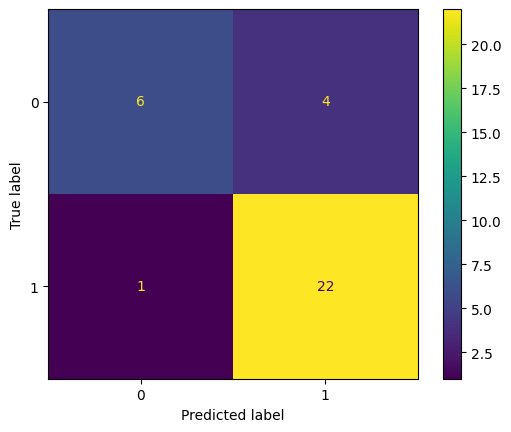

In [ ]:
evaluator_task = create_task_function(eval_prompt, model="gpt-4.1-nano")
print("Running evaluator experiment...")
experiment = run_experiment(
    dataset=dev_dataset,
    task=evaluator_task,
    evaluators=[eval_tp, eval_tn, eval_fp, eval_fn, accuracy],
    concurrency=3,
)
experiment_id = experiment.id
print(f"Experiment completed! Experiment ID: {experiment_id}")

# View experiment results
results = retrieve_results(experiment_id)
compute_metrics(results)

Uh oh. Seems that are TNR (True Negative Rate) is still high. Let's analyze failure cases again to see how we can improve our prompt.

--- 
**Ground Truth Label:** FAIL

**Predicted Label:** PASS

**Predicted Explanation:** The recipe uses natural ingredients like apples, cinnamon, walnuts, and optional honey, avoiding artificial sweeteners. Although honey is a natural sweetener, it is high in carbohydrates and not ideal for strict diabetic dietary restrictions. However, if omitted or replaced with lower glycemic sweeteners, this dessert can be suitable for diabetics. The recipe does not include artificial sweeteners or high-GI ingredients, making it a generally diabetic-friendly option when prepared appropriately.

**Ground Truth Explanation:** The recipe for Baked Apples with Cinnamon and Walnuts includes ingredients that may not be ideal for a diabetic-friendly diet. **Natural Sugars:** While the apples themselves are a natural source of sugar, the addition of honey or maple syrup, even as optional, can significantly increase the glycemic load of the dessert. **Sweetener Issues:** Diabetic-friendly recipes should focus on minimizing sugar content, and using honey or maple syrup contradicts this requirement. **High Glycemic Ingredients:** Additionally, rolled oats, though optional, can also contribute to a higher glycemic index. Therefore, the recipe does not fully adhere to the diabetic-friendly dietary restriction.

---

**Ground Truth Label**: FAIL

**Predicted Label**: PASS

**Predicted Explanation**: The recipe delivers a gluten-free pizza dough using rice flour and cornstarch, ensuring no wheat-based ingredients are used. The approach yields a dough that is both gluten-free and enjoyable, avoiding the typical cardboard texture often associated with gluten-free crusts.

**Ground Truth Explanation**: While the recipe does not contain wheat or barley, it includes malt extract for flavoring. Ingredient Violation: Malt extract is derived from barley and contains gluten, making the dough unsuitable for a gluten-free diet. Without understanding that malt extract is a gluten-containing ingredient, the model incorrectly assumes the recipe complies fully with gluten-free guidelines.

---

**Ground Truth Label**: FAIL

**Predicted Label**: PASS

**Predicted Explanation**: The recipe provides a paleo-friendly lunch using roasted vegetables, grilled chicken, olive oil, and a light almond dressing. It avoids grains, dairy, legumes, and processed sugar, making it fully compliant with paleo guidelines and a healthy lunch option.

**Ground Truth Explanation**: While the recipe avoids grains, dairy, and legumes, it includes green peas in the roasted vegetable mix. Ingredient Violation: The Paleo diet excludes legumes, which include green peas, due to their high antinutrient content and carbohydrate profile. The model fails to recognize that green peas are considered legumes and therefore non-compliant with paleo dietary rules. As a result, the recipe does not fully adhere to the paleo restriction.

#### Key insights from failures
- Our evaluator does not have precise information on the different dietary restrictions. For example it makes mistakes on technicalities related to gluten-free diets and Paleo diets. 
- Optional ingredients that violate the dietary restriction should not be included, as they fail to meet the basic standards of the query.
- There are still some issues around honey.

#### Ways we should improve the prompt
- Let's include the definitions for all of our dietary restrictions. This will ensure the model is fully informed on all the precise details of every dietary restriction, which will help it correctly classify queries. 
- Let's tell the model to not include any optional ingredients that would violate the user's query and dietary restriction.
- Let's add some few shot examples from the training set so that our model knows how to understand honey. 

From researching about prompting strategies we also know that few shot learning is helpful in general cases. It's also an intuitive way to leverage our training set! Up until now, we were just trying out prompts and not using our training set to build these prompts. But through experimentation and research about prompting, we have arrived at a good way to use it. 

## New, Refined Eval Prompt

In [ ]:
from scripts.develop_judge import select_few_shot_examples

few_shot_examples = select_few_shot_examples(train_df, num_positive=1, num_negative=3)

eval_prompt = """You are an expert nutritionist and dietary specialist evaluating whether recipe responses properly adhere to specified dietary restrictions.

DIETARY RESTRICTION DEFINITIONS:
- Vegan: No animal products (meat, dairy, eggs, honey, etc.)
- Vegetarian: No meat or fish, but dairy and eggs are allowed
- Gluten-free: No wheat, barley, rye, or other gluten-containing grains
- Dairy-free: No milk, cheese, butter, yogurt, or other dairy products
- Keto: Very low carb (typically <20g net carbs), high fat, moderate protein
- Paleo: No grains, legumes, dairy, refined sugar, or processed foods
- Pescatarian: No meat except fish and seafood
- Kosher: Follows Jewish dietary laws (no pork, shellfish, mixing meat/dairy)
- Halal: Follows Islamic dietary laws (no pork, alcohol, proper slaughter)
- Nut-free: No tree nuts or peanuts
- Low-carb: Significantly reduced carbohydrates (typically <50g per day)
- Sugar-free: No added sugars or high-sugar ingredients
- Raw vegan: Vegan foods not heated above 118°F (48°C)
- Whole30: No grains, dairy, legumes, sugar, alcohol, or processed foods.
Examples of foods that are not Whole30 compliant: honey, whole wheat flour, unsweetened dried fruits.
- Diabetic-friendly: Low glycemic index, controlled carbohydrates
Note that flour and honey are not diabetic-friendly due to their high glycemic index and carbohydrate content.
- Low-sodium: Reduced sodium content for heart health

NO OPTIONAL INGREDIENTS THAT VIOLATE THE DIETARY RESTRICTION SHOULD BE INCLUDED IN ANY FORM.

EVALUATION CRITERIA:
- PASS: The recipe clearly adheres to the dietary preferences with appropriate ingredients and preparation methods
- FAIL: The recipe contains ingredients or methods that violate the dietary preferences
- Consider both explicit ingredients and cooking methods

Here are some examples of how to evaluate dietary adherence:

"""

# Add few-shot examples
for i, example in enumerate(few_shot_examples, 1):
    eval_prompt += f"\nExample {i}:\n"
    eval_prompt += f"Query and Response: {example['attributes.output.value']}\n"
    eval_prompt += f"Explanation: {example['ground_truth_explanation']}\n"
    eval_prompt += f"Label: {example['ground_truth_label']}\n"

# Add evaluation template - using placeholders that won't conflict with JSON
eval_prompt += """

Now evaluate the following recipe response:

Query: {attributes.query}
Dietary Restriction: {attributes.dietary_restriction}
Recipe Response: {attributes.output.value}

MAKE SURE TO RETURN YOUR EVALUATION IN THE FOLLOWING JSON FORMAT:
"label": "PASS" or "FAIL",
"explanation": "Detailed explanation of your evaluation, citing specific ingredients or methods"
"""

Selecting random few-shot examples...

Selected 4 few-shot examples (1 PASS, 3 FAIL)

###  Test on Dev set

/Users/priyanjindal/recipe-chatbot/.venv/lib/python3.13/site-packages/phoenix/utilities/client.py:60: UserWarning: The Phoenix server (11.13.2) and client (11.18.0) versions are mismatched and may have compatibility issues.
  warnings.warn(
🐌!! If running inside a notebook, patching the event loop with nest_asyncio will allow asynchronous eval submission, and is significantly faster. To patch the event loop, run `nest_asyncio.apply()`.


Running evaluator experiment...
🧪 Experiment started.
📺 View dataset experiments: http://127.0.0.1:6006/datasets/RGF0YXNldDo0/experiments
🔗 View this experiment: http://127.0.0.1:6006/datasets/RGF0YXNldDo0/compare?experimentId=RXhwZXJpbWVudDoxMg==


running tasks |          | 0/29 (0.0%) | ⏳ 00:00<? | ?it/s/Users/priyanjindal/recipe-chatbot/.venv/lib/python3.13/site-packages/pydantic/main.py:463: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected 9 fields but got 6: Expected `Message` - serialized value may not be as expected [input_value=Message(content='{\n  "la...: None}, annotations=[]), input_type=Message])
  PydanticSerializationUnexpectedValue(Expected `StreamingChoices` - serialized value may not be as expected [input_value=Choices(finish_reason='st...ider_specific_fields={}), input_type=Choices])
  return self.__pydantic_serializer__.to_python(
running tasks |██████████| 29/29 (100.0%) | ⏳ 01:19<00:00 |  2.74s/it
🐌!! If running inside a notebook, patching the event loop with nest_asyncio will allow asynchronous eval submission, and is significantly faster. To patch the event loop, run `nest_asyncio.apply()`.


✅ Task runs completed.
🧠 Evaluation started.


running experiment evaluations |          | 0/145 (0.0%) | ⏳ 00:00<? | ?it/s/Users/priyanjindal/recipe-chatbot/.venv/lib/python3.13/site-packages/phoenix/utilities/client.py:60: UserWarning: The Phoenix server (11.13.2) and client (11.18.0) versions are mismatched and may have compatibility issues.
  warnings.warn(
running experiment evaluations |██████████| 145/145 (100.0%) | ⏳ 00:01<00:00 | 136.18it/s


🔗 View this experiment: http://127.0.0.1:6006/datasets/RGF0YXNldDo0/compare?experimentId=RXhwZXJpbWVudDoxMg==

Experiment Summary (08/05/25 12:39 AM -0700)
--------------------------------------------
  evaluator   n  n_scores  avg_score  n_labels              top_2_labels
0  accuracy  29        29   1.000000        29              {'True': 29}
1   eval_fn  29        29   0.000000        29             {'False': 29}
2   eval_fp  29        29   0.000000        29             {'False': 29}
3   eval_tn  29        29   0.310345        29  {'False': 20, 'True': 9}
4   eval_tp  29        29   0.689655        29  {'True': 20, 'False': 9}

Tasks Summary (08/05/25 12:39 AM -0700)
---------------------------------------
   n_examples  n_runs  n_errors
0          29      29         0
Experiment completed! Experiment ID: RXhwZXJpbWVudDoxMg==


Judge Performance on Dev Set:

True Positive Rate (TPR): 1.000

True Negative Rate (TNR): 1.000

Balanced Accuracy: 1.000

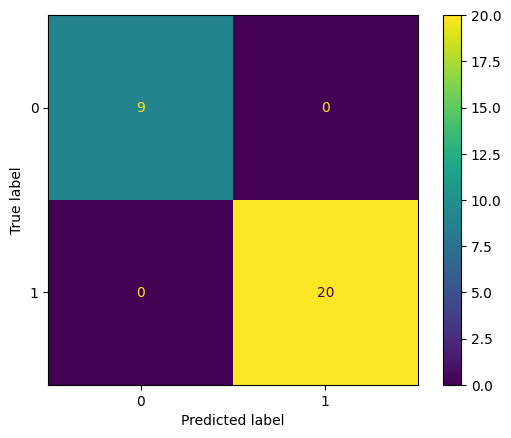

/Users/priyanjindal/recipe-chatbot/.venv/lib/python3.13/site-packages/pydantic/main.py:463: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected 9 fields but got 6: Expected `Message` - serialized value may not be as expected [input_value=Message(content='{\n  "la...: None}, annotations=[]), input_type=Message])
  PydanticSerializationUnexpectedValue(Expected `StreamingChoices` - serialized value may not be as expected [input_value=Choices(finish_reason='st...ider_specific_fields={}), input_type=Choices])
  return self.__pydantic_serializer__.to_python(
/Users/priyanjindal/recipe-chatbot/.venv/lib/python3.13/site-packages/pydantic/main.py:463: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected 9 fields but got 6: Expected `Message` - serialized value may not be as expected [input_value=Message(content='{\n  "la...: None}, annotations=[]), input_type=Message])
  PydanticSerializationUnexpectedValue(Expected `S

In [11]:
evaluator_task = create_task_function(eval_prompt, model="gpt-4.1-nano")
print("Running evaluator experiment...")
experiment = run_experiment(
    dataset=dev_dataset,
    task=evaluator_task,
    evaluators=[eval_tp, eval_tn, eval_fp, eval_fn, accuracy],
    concurrency=3,
)
experiment_id = experiment.id
print(f"Experiment completed! Experiment ID: {experiment_id}")

# View experiment results
results = retrieve_results(experiment_id)
compute_metrics(results)

## Test Set

Awesome! We were able to achieve 100% accuracy on the dev set with our changes! Let's test on our test set now to ensure that our evaluator can model queries in general cases, and has not overfit to our training set. 

/Users/priyanjindal/recipe-chatbot/.venv/lib/python3.13/site-packages/phoenix/utilities/client.py:60: UserWarning: The Phoenix server (11.13.2) and client (11.18.0) versions are mismatched and may have compatibility issues.
  warnings.warn(


Running evaluator experiment...
🧪 Experiment started.
📺 View dataset experiments: http://127.0.0.1:6006/datasets/RGF0YXNldDo1/experiments
🔗 View this experiment: http://127.0.0.1:6006/datasets/RGF0YXNldDo1/compare?experimentId=RXhwZXJpbWVudDoxNQ==


running tasks |█████████▍| 31/33 (93.9%) | ⏳ 02:14<00:07 |  3.58s/it

✅ Task runs completed.
🧠 Evaluation started.


running tasks |██████████| 33/33 (100.0%) | ⏳ 02:15<00:00 |  4.10s/it



🔗 View this experiment: http://127.0.0.1:6006/datasets/RGF0YXNldDo1/compare?experimentId=RXhwZXJpbWVudDoxNQ==

Experiment Summary (08/05/25 11:00 AM -0700)
--------------------------------------------
  evaluator   n  n_scores  avg_score  n_labels               top_2_labels
0  accuracy  33        33   0.969697        33   {'True': 32, 'False': 1}
1   eval_fn  33        33   0.030303        33   {'False': 32, 'True': 1}
2   eval_fp  33        33   0.000000        33              {'False': 33}
3   eval_tn  33        33   0.303030        33  {'False': 23, 'True': 10}
4   eval_tp  33        33   0.666667        33  {'True': 22, 'False': 11}

Tasks Summary (08/05/25 10:59 AM -0700)
---------------------------------------
   n_examples  n_runs  n_errors
0          33      33         0
Experiment completed! Experiment ID: RXhwZXJpbWVudDoxNQ==


Judge Performance on Dev Set:

True Positive Rate (TPR): 0.957

True Negative Rate (TNR): 1.000

Balanced Accuracy: 0.978

running experiment evaluations |██████████| 165/165 (100.0%) | ⏳ 00:19<00:00 |  8.62it/s


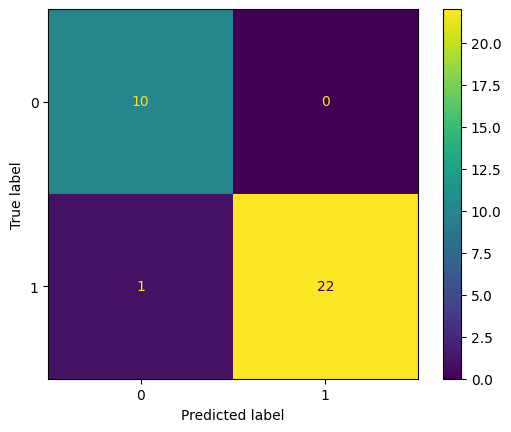

In [18]:
evaluator_task = create_task_function(eval_prompt, model="gpt-4.1-nano")
print("Running evaluator experiment...")
experiment = run_experiment(
    dataset=test_dataset,
    task=evaluator_task,
    evaluators=[eval_tp, eval_tn, eval_fp, eval_fn, accuracy],
    concurrency=3,
)
experiment_id = experiment.id
print(f"Experiment completed! Experiment ID: {experiment_id}")

# View experiment results
results = retrieve_results(experiment_id)
compute_metrics(results)

## Save Results

Awesome! We've got strong results on our test set. Let's save our results and our predictions. We will be using this later.

In [27]:
from scripts.evaluate_judge import save_results

results_dir = "results"
test_traces = pd.read_csv("data/test_set.csv")

tpr = 0.957
tnr = 1.000

predictions_data = []
for idx, entry in enumerate(results):
    # Extract prediction and ground truth
    prediction = entry.get("output", {})
    test_data = test_traces.iloc[idx]

    predictions_data.append(
        {
            "ground_truth_label": test_data.get("ground_truth_label"),
            "llm_as_judge_label": prediction.get("label"),
            "explanation": prediction.get("explanation"),
            "attributes.query": test_data.get("attributes.query"),
            "attributes.dietary_restriction": test_data.get("attributes.dietary_restriction"),
            "attributes.output.value": test_data.get("attributes.output.value"),
        }
    )

predictions = pd.DataFrame(predictions_data)
save_results(tpr, tnr, predictions, results_dir)

Saved performance metrics to results/judge_performance.json

Saved test predictions to results/test_predictions.json

Saved judgy test data to results/judgy_test_data.json

In [10]:
from scripts.run_full_evaluation import (
    compute_metrics_with_judgy,
    load_test_data,
    load_traces_from_phoenix,
    print_interpretation,
    run_judge_on_traces,
    save_final_results,
)

all_traces = load_traces_from_phoenix()
binary_predictions, predictions_df = run_judge_on_traces(eval_prompt, all_traces)
print(f"Completed evaluation of {len(binary_predictions)} traces")
print(f"Raw success rate: {np.mean(binary_predictions):.3f}")

judgy_path = "results/judgy_test_data.json"
test_labels, test_preds = load_test_data(judgy_path)

theta_hat, lower_bound, upper_bound, raw_success_rate = compute_metrics_with_judgy(
    test_labels, test_preds, binary_predictions
)

print_interpretation(theta_hat, lower_bound, upper_bound, raw_success_rate)
save_final_results(
    theta_hat, lower_bound, upper_bound, raw_success_rate, len(all_traces), results_dir
)

Loading traces from Phoenix...

Loaded 1000 traces from Phoenix

Running judge on 1000 traces with Phoenix evals...

llm_generate |██████████| 1000/1000 (100.0%) | ⏳ 02:54<00:00 |  8.51it/s

Completed labeling of 1000 traces

Completed LLM-as-Judge Evaluation, logged to Phoenix

Completed evaluation of 1000 traces
Raw success rate: 0.827


Final Results:

==============================

Raw Observed Success Rate: 0.827 (82.7%)

Corrected Success Rate: 0.865 (86.5%)

95% Confidence Interval: [0.827, 0.965]

                        [82.7%, 96.5%]

Correction Applied: 0.038 (3.8 percentage points)

llm_generate |██████████| 1000/1000 (100.0%) | ⏳ 02:56<00:00 |  5.68it/s


NameError: name 'results_dir' is not defined